<a href="https://colab.research.google.com/github/chandagrover/Machine-Learning/blob/master/4WithoutProperty_SMILEVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Installs and Imports**

In [1]:
# 10 tricks for a better Google Colab experience
# https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82
# %load_ext google.colab.data_table

In [1]:
!sudo apt-get install software-properties-common
!sudo add-apt-repository ppa:ubuntu-toolchain-r/test
!sudo apt-get update
!sudo apt-get install gcc-4.9
!sudo apt-get upgrade libstdc++6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
software-properties-common is already the newest version (0.96.24.32.14).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
 Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

 More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https

In [2]:
# !pip install keras==2.2.4
%tensorflow_version 1.x
import keras
import tensorflow as tf
print("Keras: %s"%keras.__version__)
print("Tensorflow: %s"%tf.__version__)


TensorFlow 1.x selected.


Using TensorFlow backend.


Keras: 2.3.1
Tensorflow: 1.15.2


In [3]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


--2021-01-06 09:05:48--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2021-01-06 09:05:48--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | failed with initial froz

In [5]:
# !strings /usr/lib/x86_64-linux-gnu/libstdc++.so.6 | grep GLIBCXX

In [4]:
# General Imports
import os
import pandas as pd
import numpy as np
import sklearn
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import re
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# FOR VAE Architecture 
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
print("RDKit: %s"%rdkit.__version__)
# Checking if GPU is enabled or not
tf.test.gpu_device_name()



RDKit: 2020.09.3


'/device:GPU:0'

# **Data Fetching**

In [71]:
# mount Google Drive
from google.colab import drive
drive.mount('/drive')
WEIGHTS_FOLDER = 'sample_data/weights/'
import csv
smifile ='/drive/My Drive/ZINC/Data/ZINC_Data/SMILEWithProp.csv'      #"sample_data/SMILEWithoutProp.csv"
data = pd.read_csv(smifile, delimiter = ",", header='infer', encoding='utf-8')
# smifile ='/drive/My Drive/ZINC/Data/ZINC_Data/AAAA.smi'      
# data = pd.read_csv(smifile, delimiter = " ", header='infer', encoding='utf-8')
data.smiles = data.smiles.replace('\n','', regex=True)
NUM_SMILES = len(data)
data.head()

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [76]:
print(type(data.smiles.items))
data= data[data['smiles'].str.len()<70]
print(data.smiles.count())
print(len(data))

<class 'method'>
8108
8108


In [77]:
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data, test_size=0.2, shuffle=False)
print(smiles_train.shape)
print(smiles_test.shape)
print(NUM_SMILES)

(6486, 4)
(1622, 4)
8179


In [11]:
# logP_train = smiles_train['logP']
# logP_test = smiles_test['logP']

# qed_train=smiles_train['qed']
# qed_test=smiles_test['qed']

# SAS_train=smiles_train['SAS']
# SAS_test=smiles_test['SAS']

# train=np.array([SAS_train])   #logP_train, qed_train, SAS_train
# test= np.array([SAS_test])             #logP_test, qed_test, SAS_test
# y_train_property=train.transpose()
# y_test_property=test.transpose()

In [12]:
#Labels for the Smiles String. We will deal with three properties values.
# print(type(y_train_property))
# print(type(y_test_property))
# print(y_train_property.shape)
# print(y_test_property.shape)

### **Vector Representation of Data**

In [78]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# embed = max([len(smile) for smile in data.smiles]) + 5
embed = max([len(smile) for smile in data.smiles])+2
# print(char_to_int)
print(int_to_char)
print(len(charset), embed)
# print(embed)

{0: '1', 1: ')', 2: 'C', 3: 'c', 4: '!', 5: '7', 6: '5', 7: 'H', 8: 'B', 9: 's', 10: 'N', 11: '6', 12: 'O', 13: 'S', 14: 'n', 15: '-', 16: 'P', 17: ']', 18: '=', 19: '/', 20: 'l', 21: '\\', 22: 'r', 23: 'E', 24: 'F', 25: 'I', 26: '2', 27: '3', 28: '4', 29: 'o', 30: '#', 31: '@', 32: '(', 33: '+', 34: '['}
35 71


In [79]:
def vectorize(smiles):
        onehot_flatList=[[]]
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        print(one_hot.shape)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,:,:]

X_train= vectorize(smiles_train['smiles'].values)
X_test = vectorize(smiles_test['smiles'].values)

(6486, 71, 35)
(1622, 71, 35)


### **Checking if Vectorization works!!**

Cc1cccc(NC(=O)CN2CCN(c3ccc4c(c3)OCCO4)C2=O)n1


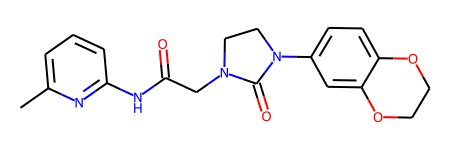

In [80]:
idx=145
print(smiles_train['smiles'][idx])
from rdkit.Chem.Draw import IPythonConsole
mol = Chem.MolFromSmiles(smiles_train['smiles'][idx])
mol

45
Cc1cccc(NC(=O)CN2CCN(c3ccc4c(c3)OCCO4)C2=O)n1


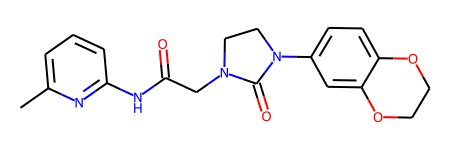

In [81]:
# Going back from vectorized form back to a readable string
smi="".join([int_to_char[idx] for idx in np.argmax(X_train[idx,:,:], axis=1)])
# String After Tructation of extra symbols
smi = re.sub('[!E]', '', smi)
print(len(smi))
print(smi)
mol = Chem.MolFromSmiles(smi)
mol

In [82]:
mol_size_x=X_train.shape[1]
mol_size_y=X_train.shape[2]
orig_dim = mol_size_x * mol_size_y
# print(mol_size_x)
# print(mol_size_y)
print(orig_dim)
X_train = np.reshape(X_train, [-1, orig_dim])
X_test = np.reshape(X_test, [-1, orig_dim])
# print(type(X_train))
# print(X_train.shape)
# print(X_train.shape[1])

2485


# **VAE**

In [110]:
# Network Parameters
INPUT_DIM=(orig_dim,)   # SMILES dimension
intermediate_dim=512
BATCH_SIZE=5
Z_DIM=30 # Dimension of the latent vector (z)
epochs=50
pre_trained=False

### **Encoder**

In [111]:
# ENCODER
def build_vae_encoder(input_dim, output_dim):
  
  # Clear tensorflow session to reset layer
  global K
  K.clear_session()
  
  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  
  #Intermediate layer
  x = Dense(intermediate_dim,activation='relu', name='hidden')(encoder_input)
 
  #Model Output
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer in the model
  encoder_output = Lambda(sampling, output_shape=(2,), name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, Model(encoder_input, encoder_output, name='encoder')



### **Decoder**

In [112]:
# Decoder
def build_decoder(input_dim, output_dim):

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')
  
  #Intermediate Layer
  x = Dense(intermediate_dim, activation='relu', name='hidden')(decoder_input)

    # Define model output
  decoder_output = Dense(output_dim, activation='sigmoid', name='decoder_lastlayer')(x)


  return decoder_input, decoder_output, Model(decoder_input, decoder_output, name='decoder')




### **Predictor**

In [21]:
# def create_predictor_linear():
#     '''
#     Creates a regressor that estimates property values 
#     from latent variables.
#     '''
#     predictor_input = layers.Input(shape=(Z_DIM,), name='predictor_input', dtype='float32')
    
#     x = layers.Dense(10, activation='relu', name='hidden')(predictor_input)
#     x = layers.Dense(1, activation='linear', name='predictor_lastlayer', dtype='float32')(x)
#     return Model(predictor_input, x, name='predictor')


### **Creating the OverAll Model**

In [113]:
# Model Creation 
def create_model():

  #Creating Encoder
  vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,                                                                                         output_dim = Z_DIM)
# vae_encoder.summary()
  
  
  #Creating Decoder
  vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM, output_dim=orig_dim)
# vae_decoder.summary()

  # #Creating the Predictor
  # predictor = create_predictor_linear()
  # t_predicted = predictor(mean_mu)
  


  #Creating the VAE Model 
  vae_input = vae_encoder_input

  # Output will be the output of the decoder. The term - decoder(encoder_output) 
  vae_output = vae_decoder(vae_encoder_output)

  # # VAE Model with Predictor
  # vae_predictor = Model(vae_input, [vae_output,t_predicted], name='VAE_with_Predictor')
# VAE Model without Property Predictor
  vae_without_predictor = Model(vae_input, vae_output, name='VAE_without_Predictor')



  return vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder, vae_decoder_input, vae_decoder_output, vae_decoder, vae_input, vae_output, vae_without_predictor

#Creating the overall Model
encoder_input, encoder_output,  mean_mu, log_var, encoder, decoder_input, decoder_output, decoder, vae_input, vae_output, vae_without_predictor = create_model()



### **VAE Loss Function**

In [114]:
#VAE Loss Function
def vae_loss(vae_input, vae_output):
  reconstruction_loss = binary_crossentropy(vae_input, vae_output)
  reconstruction_loss = reconstruction_loss * orig_dim
    
  kl_loss = 1 + log_var - K.square(mean_mu) - K.exp(log_var)
  kl_loss = K.sum(kl_loss, axis=-1)    
  kl_loss = kl_loss * -0.5
  kl_weight=0.5
  reconst_weight=0.5
    
  # vae_loss_val = K.mean(reconstruction_loss + kl_loss)
  vae_loss_val=kl_weight * kl_loss + reconst_weight * reconstruction_loss
  return vae_loss_val


**Plotting all models**

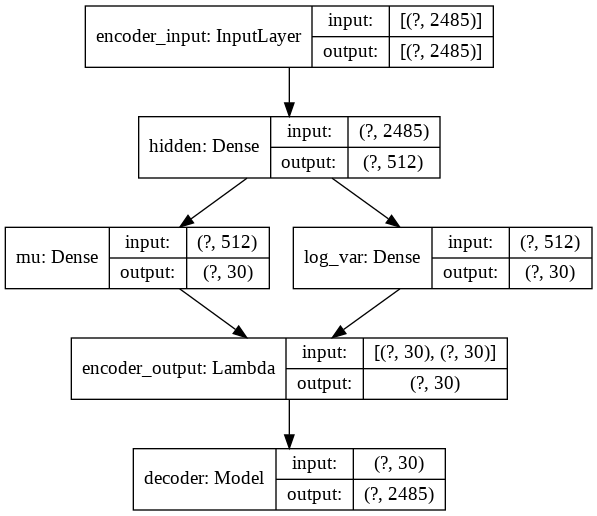

In [115]:
# Plot the Encoder Model
plot_model(encoder, to_file='/drive/My Drive/ZINC/Models/WithoutProperty/Diagram/only_encoder.png', show_shapes=True, show_layer_names=True)  #, expand_nested=True

# Plot the Decoder Model
plot_model(decoder, to_file='/drive/My Drive/ZINC/Models/WithoutProperty/Diagram/only_decoder.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

# #Plot the Predictor Model
# plot_model(predictor, to_file='/drive/My Drive/ZINC/Models/WithoutProperty/Diagram/only_predictor.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

# Plot the VAE-Predictor Model
plot_model(vae_without_predictor, to_file='/drive/My Drive/ZINC/Models/WithoutProperty/Diagram/smilesvae_without_predictor.png', show_shapes=True, show_layer_names=True)   #, expand_nested=False

# plot_model(vae_model, to_file='smilesvae_model.png', show_shapes=True, show_layer_names=True)   #, expand_nested=False

**Checkpoint**

In [116]:
# Creating Model Checkpoint for training...

checkpoint_path = "/drive/My Drive/ZINC/Models/WithoutProperty/Weights/train_ckpt/cp.ckpt"
new_check_path="/drive/My Drive/ZINC/Models/WithoutProperty/Weights/VAE_Without_Predictor{epoch:02d}-{val_loss:.2f}.h5"           #'VAE_Predictor{epoch:02d}.h5'
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=new_check_path, verbose=1, save_weights_only=False, save_best_only=True)   #, save_freq=5

# Loading weights from the latest checkpoints
#get the latest checkpoint file
checkpoint_dir = os.path.dirname(new_check_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

### **Training or Loading the VAE Model**

In [117]:
pre_trained=False
epochs=100
if __name__ == '__main__':          
#     Train the Variational AutoEncoder
    if pre_trained==False:
      vae_without_predictor.compile(optimizer='adam', 
                      loss=[vae_loss]) 
      history = vae_without_predictor.fit(x=X_train,
                            y=[X_train], 
                            epochs=epochs,
                            validation_data=(X_test, [X_test]),
                            verbose=2,
                            callbacks=[cp_callback] )  
      vae_without_predictor.save(new_check_path)
    else:
      vae_without_predictor.load_weights(new_check_path)
      history = vae_without_predictor.fit(x=X_train,
                            y=[X_train], 
                            epochs=epochs,
                            validation_data=(X_test, [X_test]),
                            verbose=2,
                            callbacks=[cp_callback]) 
      vae_without_predictor.save(new_check_path)
    

Train on 6486 samples, validate on 1622 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 90.37090, saving model to /drive/My Drive/ZINC/Models/WithoutProperty/Weights/VAE_Without_Predictor01-90.37.h5
6486/6486 - 1s - loss: 127.3439 - val_loss: 90.3709
Epoch 2/100

Epoch 00002: val_loss improved from 90.37090 to 84.44895, saving model to /drive/My Drive/ZINC/Models/WithoutProperty/Weights/VAE_Without_Predictor02-84.45.h5
6486/6486 - 1s - loss: 86.4990 - val_loss: 84.4489
Epoch 3/100

Epoch 00003: val_loss improved from 84.44895 to 79.31187, saving model to /drive/My Drive/ZINC/Models/WithoutProperty/Weights/VAE_Without_Predictor03-79.31.h5
6486/6486 - 1s - loss: 81.0223 - val_loss: 79.3119
Epoch 4/100

Epoch 00004: val_loss improved from 79.31187 to 75.71886, saving model to /drive/My Drive/ZINC/Models/WithoutProperty/Weights/VAE_Without_Predictor04-75.72.h5
6486/6486 - 1s - loss: 76.2700 - val_loss: 75.7189
Epoch 5/100

Epoch 00005: val_loss improved from 75.71886 to 72.

In [23]:
# print(type(history))
# print(type(history.history))
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


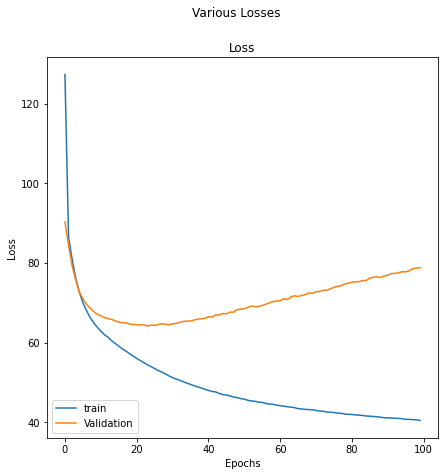

In [118]:
# summarize history for loss
fig, (ax1) = plt.subplots(1, 1, figsize=(7,7))
fig.suptitle('Various Losses')


ax1.plot(history.history['loss'])
ax1.plot( history.history['val_loss'])
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['train', 'Validation'], loc='lower left')


# ax2.plot(history.history['decoder_loss'])
# ax2.plot(history.history['val_decoder_loss'])
# ax2.set_title('Decoder Loss')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Decoder Loss')
# ax2.legend(['train', 'Validation'], loc='lower left')

# ax3.plot(history.history['predictor_loss']) 
# ax3.plot(history.history['val_predictor_loss'])
# ax3.set_title('Predictor Loss')
# ax3.set_xlabel('Epochs')
# ax3.set_ylabel('Predictor Loss')
# ax3.legend(['train', 'Validation'], loc='lower left')

# **Latent Space Visualization**

### **Each Component of latent space**

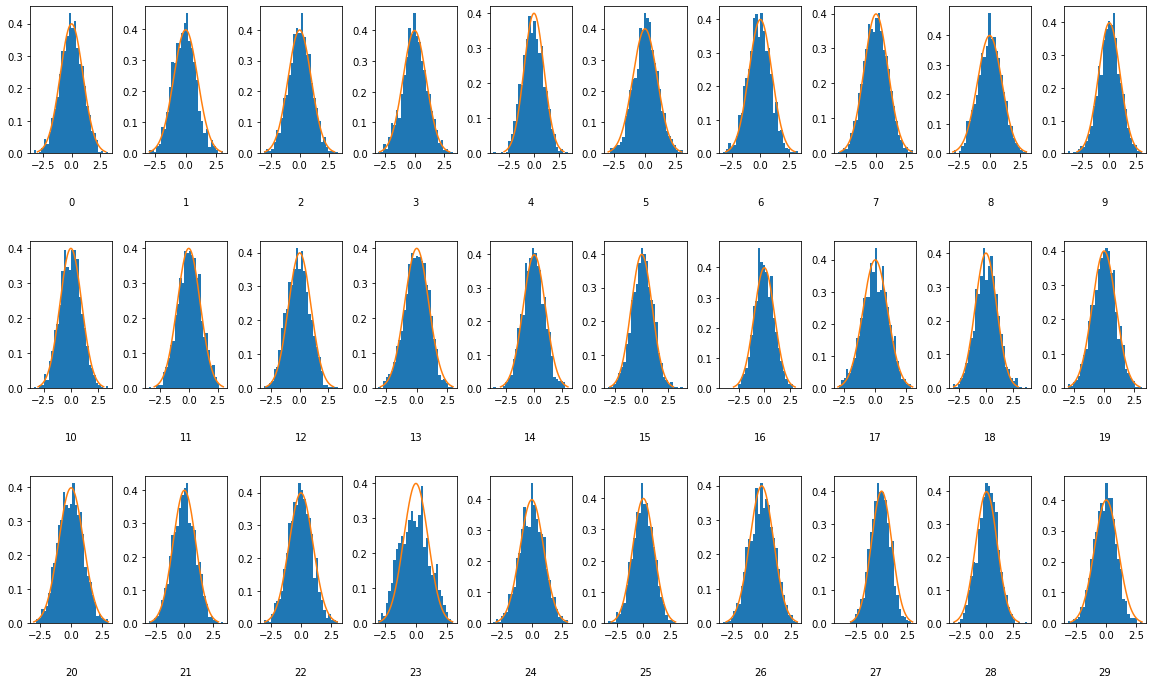

In [121]:
from scipy.stats import norm
# with graph.as_default():   # We are using this statement to reuse the last saved trained model
z_test = encoder.predict(X_test)

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(
    30):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 30)
    ax.axis('on')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

In [30]:
# from sklearn.manifold import TSNE
# z_mean = encoder.predict(X_test)
# # print(z_mean)
# model_name='VAESMILES_Latent'
# os.makedirs(model_name, exist_ok=True)
# filename = os.path.join(model_name, "smilesvae_mean.png")

# # z_embedded = TSNE(n_components=2).fit_transform(z_mean)
# plt.figure(figsize=(7,7))
# plt.scatter(z_mean[:, 0], z_mean[:, 1], c=SAS_test)
# plt.colorbar()
# plt.xlabel("z[0]")
# plt.ylabel("z[1]")
# plt.title('SAS on test data')
# plt.savefig(filename)
# plt.show()

# **Reconstruction**


In [31]:
# # Calculating mean and standard deviation of all property values on test data

# SAS_mean_test= np.mean(y_test_property, axis=0)
# SAS_std_test = np.std(y_test_property, axis=0)


In [122]:
# encoded, decoded and predicted data on test dataset

encoded_xtest=encoder.predict(X_test)
# predicted_xtest=predictor.predict(encoded_xtest)
decoded_xtest=decoder.predict(encoded_xtest)
print(encoded_xtest.shape)
# print(predicted_xtest.shape)
print(decoded_xtest.shape)

# Reshaping the original and reconstructed test data
orig_test=X_test.reshape(len(X_test), mol_size_x, mol_size_y)
reconst_test = decoded_xtest.reshape(len(X_test), mol_size_x,mol_size_y)
print(orig_test.shape)
print(reconst_test.shape)

(1622, 30)
(1622, 2485)
(1622, 71, 35)
(1622, 71, 35)


### **Reconstruction and Prediction on Original test data set**

1622 Original Valid Test Samples
4 Reconstructed Valid Test Samples
Molecule 692 Original Valid CCC[C@H]1C[C@@H]1NC(=O)CNC(=O)NC
Molecule 692 Reconstructed Valid CCC[C@H]1C[C@@H](CC(=O)CCCC=O)C1
Molecule 870 Original Valid COc1ccc2nc(NC[C@@H](C)CSC)sc2c1
Molecule 870 Reconstructed Valid COc1c2c(Sc2CC[C@@H](C)CCC)cccc1
Molecule 1330 Original Valid Cc1ccc(NC(=O)CSc2nnc(C3CC3)n2Cc2ccccc2)cc1C
Molecule 1330 Reconstructed Valid Cc1ccc(NC(=O)C)c2ccc(C(=O)nn1)c1cccccc2c1CC
Molecule 1393 Original Valid Cc1cccc(C)c1NC(=O)c1cnc2sccn2c1=O
Molecule 1393 Reconstructed Valid Cc1cccc(C)c1NC(=O)c(ccccccc1)C1


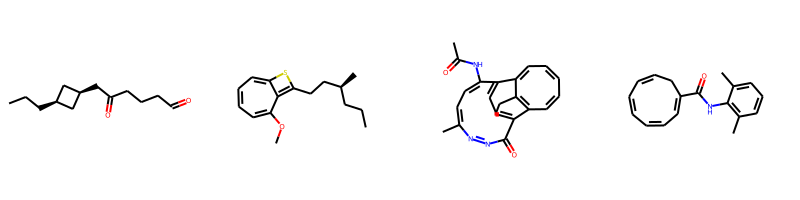

In [143]:
# Going back from vectorized form back to a readable string on original test data
IPythonConsole.ipython_useSVG=True 
mols_orig_test= []
smi_orig_test=[]
syntax_val={0:[], 1:[]}

for id in range(len(X_test)):
  smi="".join([int_to_char[idx] for idx in np.argmax(orig_test[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_orig_test.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_orig_test.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid SMiles" ,sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)
      # print(mol)
    except:
      print('Mol {} {}'.format(id+1, mol)) 


smi_orig_test_valid=[]
mols_orig_test_valid=[]
for item in syntax_val[1]:
  smi_orig_test_valid.append(smi_orig_test[item])
  mols_orig_test_valid.append(mols_orig_test[item])
# smi_orig_test_valid


print(len(mols_orig_test_valid), "Original Valid Test Samples")
# Draw.MolsToGridImage(mols_orig_test_valid, molsPerRow=4,subImgSize=(200,200))



### **Reconstruction on reconstructed test data**

from rdkit import RDLogger  
# Going back from vectorized form back to a readable string on original test data
#Reconstruction
syntax_val={0:[], 1:[]}
mols_reconst_test= []
smi_reconst_test=[]

RDLogger.DisableLog('rdApp.*')  

for id in range(len(X_test)):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_test[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_reconst_test.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_test.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Reconstructed Smile", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol, kekulize=False)
    except:
      # print('Mol {} {}'.format(id+1, mol)) 
      continue


smi_reconst_test_valid=[]
mols_reconst_test_valid=[]
smi_orig_test_valid=[]
mols_orig_test_valid=[]

print(len(syntax_val[1]), "Reconstructed Valid Test Samples")
for item in syntax_val[1]:
  smi_reconst_test_valid.append(smi_reconst_test[item])
  smi_orig_test_valid.append(smi_orig_test[item])

  mols_reconst_test_valid.append(mols_reconst_test[item])
  mols_orig_test_valid.append(mols_orig_test[item])
  print("Molecule", item, "Original Valid", smi_orig_test[item] )
  print("Molecule", item, "Reconstructed Valid", smi_reconst_test[item])

Draw.MolsToGridImage(mols_reconst_test_valid, molsPerRow=4,subImgSize=(200,200))



## **Reconstruction on reconstructed Training data**

6486 Original Valid Training Samples
169 Reconstructed Valid Training Samples
Molecule 26 Original Valid CC[C@H](C)C[C@@H](C)NC(=O)N1CCN(CC(=O)NC2CC2)CC1
Molecule 26 Reconstructed valid CC[C@H](C)C[C@@H](C)NC(=O)N1CCC(CC(=O)NC2CC2)CC1
Molecule 41 Original Valid O=C(CCCO)Nc1ccc(F)cc1F
Molecule 41 Reconstructed valid O=C(CCCC)Nc1ccc(F)cc1F
Molecule 51 Original Valid COc1ccc([C@@H](C)NC(=O)Cc2cccc3ccccc23)cc1
Molecule 51 Reconstructed valid COc1ccc([C@@H](C)NC(=O)Cc2ccc3cccccc23)C1C
Molecule 77 Original Valid Cc1cc(N(C)C)ccc1NC(=O)c1ccc(CN2CC[NH+](C)CC2)cc1
Molecule 77 Reconstructed valid CS(=O)(CC)N1cccc(C(=O)c2ccc(C)CCC[NH+](C)CC2)cc1
Molecule 143 Original Valid CC[C@@H]1CCCCN1C(=O)NC1CCN(C(=O)OC(C)(C)C)CC1
Molecule 143 Reconstructed valid CC[C@@H]1CCCCN1C(=O)NC1CCN(C(=C)OC(C)CC)CCC1
Molecule 150 Original Valid CCOCCCNC(=O)N[C@@H]1CCC[C@@H](CC)C1
Molecule 150 Reconstructed valid CCOCCCNC(=O)C[C@@H]1CCC[C@@H](CO)C1
Molecule 236 Original Valid CSc1ccccc1NC(=O)N[C@@H](CO)c1ccc(Cl)cc1
Molec

/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


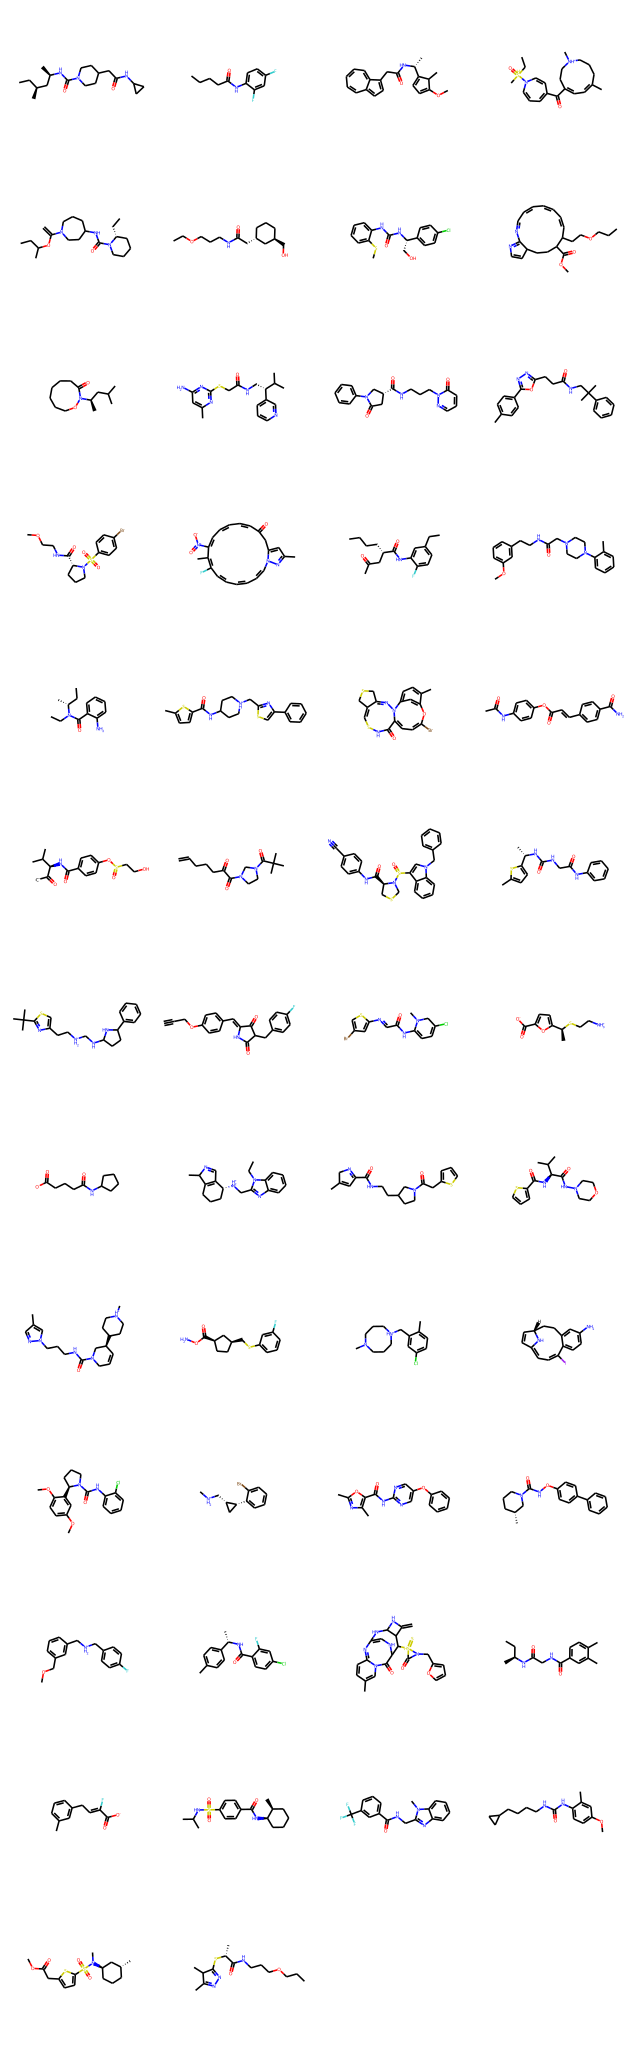

In [144]:
# encoded, decoded and predicted data on Training dataset

encoded_xtrain=encoder.predict(X_train)
# predicted_xtest=predictor.predict(encoded_xtrain)
decoded_xtrain=decoder.predict(encoded_xtrain)
# print(encoded_xtrain.shape)
# print(predicted_xtrain.shape)
# print(decoded_xtrain.shape)

# Reshaping the original and reconstructed train data
orig_train=X_train.reshape(len(X_train), mol_size_x, mol_size_y)
reconst_train = decoded_xtrain.reshape(len(X_train), mol_size_x,mol_size_y)
# print(orig_train.shape)
# print(reconst_train.shape)
# Going back from vectorized form back to a readable string on original training data

syntax_val={0:[], 1:[]}

smi_orig_train=[]
mols_orig_train= []

for id in range(len(X_train)):
  smi="".join([int_to_char[idx] for idx in np.argmax(orig_train[id,:,:], axis=1)])
  smi = re.sub('!|E',"", smi)
  smi_orig_train.append(smi)

  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_orig_train.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(mol), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)
    except:
      print('Mol {} {}'.format(id+1, mol)) 

smi_orig_train_valid=[]
mols_orig_train_valid=[]

for item in syntax_val[1]:
  smi_orig_train_valid.append(smi_orig_train[item].rstrip('\n'))
  mols_orig_train_valid.append(mols_orig_train[item])


print(len(mols_orig_train_valid), "Original Valid Training Samples")
# Draw.MolsToGridImage(mols_orig_train_valid, molsPerRow=4,subImgSize=(200,200))

# Going back from vectorized form back to a readable string on Reconstructed training data
#Reconstruction

syntax_val={0:[], 1:[]}

smi_reconst_train=[]
mols_reconst_train= []

for id in range(len(X_train)):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_train[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_reconst_train.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_train.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol, kekulize=True)      
    except:
      # print('Mol {} {}'.format(id+1, mol)) 
      continue

smi_reconst_train_valid=[]
mols_reconst_train_valid=[]
smi_orig_train_valid=[]
mols_orig_train_valid=[]

print(len(syntax_val[1]), "Reconstructed Valid Training Samples")
for item in syntax_val[1]:
  smi_reconst_train_valid.append(smi_reconst_train[item].rstrip('\n'))
  smi_orig_train_valid.append(smi_orig_train[item].rstrip('\n'))

  mols_reconst_train_valid.append(mols_reconst_train[item])
  mols_orig_train_valid.append(mols_orig_train[item])

  print("Molecule", item,"Original Valid", smi_orig_train[item])
  print("Molecule" , item, "Reconstructed valid", smi_reconst_train[item])


Draw.MolsToGridImage(mols_reconst_train_valid, molsPerRow=4,subImgSize=(200,200))



In [136]:
print("Validity Percentage of Training Reconstructed Molecules", (len(mols_reconst_train_valid)/len(mols_reconst_train))*100, "%")
print("Validity Percentage of Testing Reconstructed Molecules", (len(mols_reconst_test_valid)/len(mols_reconst_test))*100,"%")

Validity Percentage of Training Reconstructed Molecules 2.6672833795868023 %
Validity Percentage of Testing Reconstructed Molecules 0.2466091245376079 %


# **Generating New Samples from Normal Distribution**

New valid Molecule 1 OOC1cc(ccc1cccc1C(=O)c2ccccccco2)c1
New valid Molecule 2 C[NH+](CCCCCC(CCCC)=O)NCCCCCCC
New valid Molecule 3 COc1ccc2cc(CC(=O)NCcCnCnccccc(C)cccc2)cc1
3 Valid New Moecules


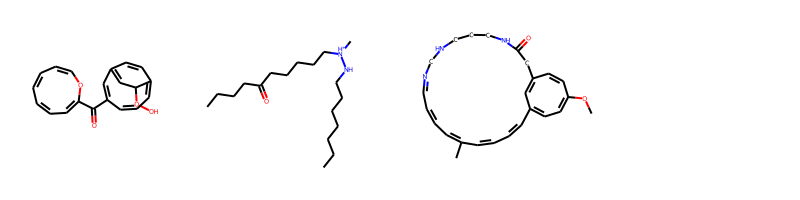

In [146]:
prop_val={}
syntax_val_new={0:[], 1:[]}


smi_reconst_new=[]
smi_reconst_new_valid=[]

mols_reconst_new= []
mols_reconst_new_valid=[]

n_mol=5000

latent_samples= np.random.normal(0,1,size=(n_mol,Z_DIM))
# print(latent_samples.shape)
# predicted_prop_samples=predictor.predict(latent_samples)


#Passing it to Decoder
reconst_sample = decoder.predict(latent_samples)
reconst_smi=reconst_sample.reshape(n_mol, mol_size_x, mol_size_y) 

for id, latent_mol in enumerate(reconst_smi):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_smi[id,:,:], axis=1)])
  smi = re.sub('!|E',"", smi)
  smi_reconst_new.append(smi)

  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_new.append(mol)
  if mol is None:
    syntax_val_new[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val_new[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid New Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)      
    except:
      print('Mol {} {}'.format(id+1, mol)) 

i=1
for item in syntax_val_new[1]:
  smi_reconst_new_valid.append(smi_reconst_new[item].rstrip('\n'))
  mols_reconst_new_valid.append(mols_reconst_new[item])
  print("New valid Molecule", i, smi_reconst_new[item])
  i=i+1

print(len(mols_reconst_new_valid), "Valid New Moecules")
Draw.MolsToGridImage(mols_reconst_new_valid, molsPerRow=4,subImgSize=(200,200))


In [ ]:
# #Checking the property of molecule
# for id, latent_mol in enumerate(latent_samples):
#   # print(id)
#   e=predicted_prop_samples[id][0]<(SAS_mean_test+SAS_std_test)
#   f=predicted_prop_samples[id][0]>=(SAS_mean_test-SAS_std_test)
#   if (syntax_val[id]==1):  #Checking if all of the property values matches
#     if (e & f):
#       prop_val[id]=1
#       print("Mol {}, Property Validated".format(id+1))
#       print("Predicted Properties=")
#       print(predicted_prop_samples[id][0])
#     else:    
#       prop_val[id]=0
#       print("Mol {}, Property Invalidated".format(id+1))  
#   else:
#     print("Invalid Molecules... Property Not Checked")
#     continue